In [1]:
import numpy as np
import json
from datasets import load_dataset
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import torch
import albumentations
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments
from transformers import Trainer
import requests
from transformers import pipeline

c:\Users\d\Documents\GitHub\deep-learning\assignment2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Deep Learning Assignment 2 - Darren Singh

## Outline of the Notebook:

The candy_counter() function can be found in the very last cell of this notebook. The cells below this one perform all of the required actions involving label-studio and the hugging face tutorial. Any modifications or note-worthy steps can be found in either the cell comments or markdown cells. These cells do include a test image with predicted bounding boxes.

The cell below is to launch the label-studio, right now it is commented out as the data labelling has already been done.

In [2]:
# start label studio to create bounding boxes

#!label-studio start

Reading the output json file from label-studio.

In [3]:
# read coco annotations
with open('result.json') as f:
    cocodata = json.load(f)

Convert the output json file from label-studio to a format that hugging face can understand. Do NOT run these cells unless this process must be done.

In [4]:
# store annotations in dictionary

# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
    # Remove the image directory from the file name
    image['file_name'] = image['file_name'].split('/')[-1]
    image['image_id'] = image['id']
    # Extend the image dict with bounding boxes and class labels
    image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
    # Iterate through the annotations (bounding boxes and labels)
    for annot in cocodata['annotations']:
        # Check if the annotation matches the image
        if annot['image_id'] == image['id']:
            # Add the annotation
            image['objects']['bbox'].append(annot['bbox'])
            image['objects']['category'].append(annot['category_id'])
            image['objects']['area'].append(annot['area'])
            image['objects']['id'].append(annot['id'])
    # Append the image dict with annotations to the list
    huggingdata.append(image)

In [5]:
# save the dictionary to a file

with open("metadata.jsonl", 'w') as f:
    for item in huggingdata:
        f.write(json.dumps(item) + "\n")

Load the dataset after organizing the directory storing the images and corresponding metadata file.

In [6]:
# read in dataset (assuming that the correct directory organization has been created)

candy_data = load_dataset('imagefolder', data_dir='data', split='train')

Code to convert from labels to ids and back.

In [7]:
id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}
id2label

{0: 'Black_star',
 1: 'Cat',
 2: 'Grey_star',
 3: 'Insect',
 4: 'Moon',
 5: 'Owl',
 6: 'Unicorn_head',
 7: 'Unicorn_whole'}

Code to visualize a single image in the dataset with its bounding boxes.

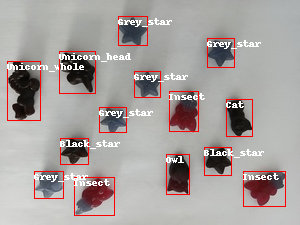

In [8]:
# visualize image

image = candy_data[0]["image"]
annotations = candy_data[0]["objects"]
draw = ImageDraw.Draw(image)

id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")
    
image

In [9]:
# pre-process data

# set checkpoint
checkpoint = "facebook/detr-resnet-50"

# instantiate image processor
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [10]:
# augment images

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params = albumentations.BboxParams(format="coco", label_fields=["category"])
)

In [11]:
# format annotations for a sinlge image
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

The cell below combines the two cells above into a single function.

In [12]:
# batch function for image transformation and annotation formatting
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [13]:
# apply function to dataset
candy_data = candy_data.with_transform(transform_aug_ann)

In [14]:
# verify transformations worked
candy_data[0]

{'pixel_values': tensor([[[0.8618, 0.8618, 0.8618,  ..., 0.9646, 0.9646, 0.9646],
          [0.8618, 0.8618, 0.8618,  ..., 0.9646, 0.9646, 0.9646],
          [0.8618, 0.8618, 0.8618,  ..., 0.9817, 0.9817, 0.9817],
          ...,
          [1.0844, 1.0844, 1.0844,  ..., 1.3927, 1.3755, 1.3755],
          [1.0844, 1.0844, 1.0844,  ..., 1.3755, 1.3755, 1.3755],
          [1.0844, 1.0844, 1.0844,  ..., 1.3755, 1.3755, 1.3755]],
 
         [[0.9930, 0.9930, 0.9930,  ..., 1.1506, 1.1506, 1.1506],
          [0.9930, 0.9930, 0.9930,  ..., 1.1506, 1.1506, 1.1506],
          [0.9930, 0.9930, 0.9930,  ..., 1.1681, 1.1506, 1.1506],
          ...,
          [1.2381, 1.2381, 1.2381,  ..., 1.5707, 1.5707, 1.5707],
          [1.2381, 1.2381, 1.2381,  ..., 1.5707, 1.5707, 1.5707],
          [1.2381, 1.2381, 1.2381,  ..., 1.5707, 1.5707, 1.5707]],
 
         [[1.1585, 1.1585, 1.1585,  ..., 1.3502, 1.3502, 1.3502],
          [1.1585, 1.1585, 1.1585,  ..., 1.3502, 1.3502, 1.3502],
          [1.1585, 1.158

In [15]:
# function to batch images together, pad images to ensure same dimensions, pixel mask to know what pixels are real vs padding
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

# apply function to dataset
# candy_data.with_transform(collate_fn)

Model training begins here:

In [16]:
# training begins

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [17]:
# set hyperparams

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=500,
    # set fp16 to false unless using cuda (nvidia gpu)
    fp16=False,
    # train for 200 epochs
    save_steps=200,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    # not sure if we need to push to hugging face
    push_to_hub=False,
)

In [18]:
# call training method

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data,
    tokenizer=image_processor,
)

trainer.train()

  1%|          | 10/1000 [01:12<1:45:58,  6.42s/it]

{'loss': 3.1531, 'learning_rate': 9.9e-06, 'epoch': 5.0}


  2%|▏         | 20/1000 [02:24<1:44:36,  6.40s/it]

{'loss': 2.5538, 'learning_rate': 9.800000000000001e-06, 'epoch': 10.0}


  3%|▎         | 30/1000 [03:36<1:45:05,  6.50s/it]

{'loss': 2.4342, 'learning_rate': 9.7e-06, 'epoch': 15.0}


  4%|▍         | 40/1000 [04:49<1:42:35,  6.41s/it]

{'loss': 2.3455, 'learning_rate': 9.600000000000001e-06, 'epoch': 20.0}


  5%|▌         | 50/1000 [06:01<1:41:46,  6.43s/it]

{'loss': 2.2723, 'learning_rate': 9.5e-06, 'epoch': 25.0}


  6%|▌         | 60/1000 [07:15<1:42:09,  6.52s/it]

{'loss': 2.2206, 'learning_rate': 9.4e-06, 'epoch': 30.0}


  7%|▋         | 70/1000 [08:27<1:39:40,  6.43s/it]

{'loss': 2.1567, 'learning_rate': 9.3e-06, 'epoch': 35.0}


  8%|▊         | 80/1000 [09:39<1:37:17,  6.35s/it]

{'loss': 2.1472, 'learning_rate': 9.200000000000002e-06, 'epoch': 40.0}


  9%|▉         | 90/1000 [10:50<1:36:47,  6.38s/it]

{'loss': 2.148, 'learning_rate': 9.100000000000001e-06, 'epoch': 45.0}


 10%|█         | 100/1000 [12:01<1:35:42,  6.38s/it]

{'loss': 2.0818, 'learning_rate': 9e-06, 'epoch': 50.0}


 11%|█         | 110/1000 [13:13<1:34:19,  6.36s/it]

{'loss': 2.05, 'learning_rate': 8.900000000000001e-06, 'epoch': 55.0}


 12%|█▏        | 120/1000 [14:24<1:33:09,  6.35s/it]

{'loss': 2.0173, 'learning_rate': 8.8e-06, 'epoch': 60.0}


 13%|█▎        | 130/1000 [15:35<1:32:20,  6.37s/it]

{'loss': 1.9982, 'learning_rate': 8.700000000000001e-06, 'epoch': 65.0}


 14%|█▍        | 140/1000 [16:47<1:31:35,  6.39s/it]

{'loss': 1.9714, 'learning_rate': 8.6e-06, 'epoch': 70.0}


 15%|█▌        | 150/1000 [17:59<1:30:47,  6.41s/it]

{'loss': 1.936, 'learning_rate': 8.5e-06, 'epoch': 75.0}


 16%|█▌        | 160/1000 [19:10<1:29:11,  6.37s/it]

{'loss': 1.8939, 'learning_rate': 8.400000000000001e-06, 'epoch': 80.0}


 17%|█▋        | 170/1000 [20:22<1:28:17,  6.38s/it]

{'loss': 1.8792, 'learning_rate': 8.3e-06, 'epoch': 85.0}


 18%|█▊        | 180/1000 [21:34<1:27:24,  6.40s/it]

{'loss': 1.8363, 'learning_rate': 8.2e-06, 'epoch': 90.0}


 19%|█▉        | 190/1000 [22:45<1:26:02,  6.37s/it]

{'loss': 1.784, 'learning_rate': 8.1e-06, 'epoch': 95.0}


 20%|██        | 200/1000 [23:57<1:24:56,  6.37s/it]

{'loss': 1.7685, 'learning_rate': 8.000000000000001e-06, 'epoch': 100.0}


 21%|██        | 210/1000 [25:08<1:23:37,  6.35s/it]

{'loss': 1.7207, 'learning_rate': 7.9e-06, 'epoch': 105.0}


 22%|██▏       | 220/1000 [26:20<1:23:00,  6.39s/it]

{'loss': 1.6931, 'learning_rate': 7.800000000000002e-06, 'epoch': 110.0}


 23%|██▎       | 230/1000 [27:31<1:21:49,  6.38s/it]

{'loss': 1.6166, 'learning_rate': 7.7e-06, 'epoch': 115.0}


 24%|██▍       | 240/1000 [28:43<1:20:39,  6.37s/it]

{'loss': 1.5626, 'learning_rate': 7.600000000000001e-06, 'epoch': 120.0}


 25%|██▌       | 250/1000 [29:54<1:19:22,  6.35s/it]

{'loss': 1.5748, 'learning_rate': 7.500000000000001e-06, 'epoch': 125.0}


 26%|██▌       | 260/1000 [31:05<1:17:51,  6.31s/it]

{'loss': 1.5298, 'learning_rate': 7.4e-06, 'epoch': 130.0}


 27%|██▋       | 270/1000 [32:16<1:17:04,  6.34s/it]

{'loss': 1.4699, 'learning_rate': 7.3e-06, 'epoch': 135.0}


 28%|██▊       | 280/1000 [33:26<1:15:47,  6.32s/it]

{'loss': 1.4189, 'learning_rate': 7.2000000000000005e-06, 'epoch': 140.0}


 29%|██▉       | 290/1000 [34:37<1:14:58,  6.34s/it]

{'loss': 1.3633, 'learning_rate': 7.100000000000001e-06, 'epoch': 145.0}


 30%|███       | 300/1000 [35:48<1:14:05,  6.35s/it]

{'loss': 1.3371, 'learning_rate': 7e-06, 'epoch': 150.0}


 31%|███       | 310/1000 [37:00<1:13:00,  6.35s/it]

{'loss': 1.3, 'learning_rate': 6.9e-06, 'epoch': 155.0}


 32%|███▏      | 320/1000 [38:11<1:11:48,  6.34s/it]

{'loss': 1.2638, 'learning_rate': 6.800000000000001e-06, 'epoch': 160.0}


 33%|███▎      | 330/1000 [39:22<1:10:40,  6.33s/it]

{'loss': 1.2247, 'learning_rate': 6.700000000000001e-06, 'epoch': 165.0}


 34%|███▍      | 340/1000 [40:32<1:08:20,  6.21s/it]

{'loss': 1.209, 'learning_rate': 6.600000000000001e-06, 'epoch': 170.0}


 35%|███▌      | 350/1000 [41:42<1:07:54,  6.27s/it]

{'loss': 1.1968, 'learning_rate': 6.5000000000000004e-06, 'epoch': 175.0}


 36%|███▌      | 360/1000 [42:53<1:07:35,  6.34s/it]

{'loss': 1.1599, 'learning_rate': 6.4000000000000006e-06, 'epoch': 180.0}


 37%|███▋      | 370/1000 [44:04<1:06:55,  6.37s/it]

{'loss': 1.1401, 'learning_rate': 6.300000000000001e-06, 'epoch': 185.0}


 38%|███▊      | 380/1000 [45:15<1:05:53,  6.38s/it]

{'loss': 1.1179, 'learning_rate': 6.200000000000001e-06, 'epoch': 190.0}


 39%|███▉      | 390/1000 [46:26<1:03:56,  6.29s/it]

{'loss': 1.0805, 'learning_rate': 6.1e-06, 'epoch': 195.0}


 40%|████      | 400/1000 [47:37<1:03:02,  6.30s/it]

{'loss': 1.0548, 'learning_rate': 6e-06, 'epoch': 200.0}


 41%|████      | 410/1000 [48:48<1:02:13,  6.33s/it]

{'loss': 1.0203, 'learning_rate': 5.9e-06, 'epoch': 205.0}


 42%|████▏     | 420/1000 [49:59<1:00:59,  6.31s/it]

{'loss': 1.0517, 'learning_rate': 5.8e-06, 'epoch': 210.0}


 43%|████▎     | 430/1000 [51:09<59:45,  6.29s/it]  

{'loss': 1.0029, 'learning_rate': 5.7e-06, 'epoch': 215.0}


 44%|████▍     | 440/1000 [52:19<58:17,  6.25s/it]  

{'loss': 0.9939, 'learning_rate': 5.600000000000001e-06, 'epoch': 220.0}


 45%|████▌     | 450/1000 [53:29<57:24,  6.26s/it]  

{'loss': 0.9483, 'learning_rate': 5.500000000000001e-06, 'epoch': 225.0}


 46%|████▌     | 460/1000 [54:40<56:21,  6.26s/it]  

{'loss': 0.9593, 'learning_rate': 5.400000000000001e-06, 'epoch': 230.0}


 47%|████▋     | 470/1000 [55:50<55:26,  6.28s/it]  

{'loss': 0.9274, 'learning_rate': 5.300000000000001e-06, 'epoch': 235.0}


 48%|████▊     | 480/1000 [57:00<54:13,  6.26s/it]  

{'loss': 0.8908, 'learning_rate': 5.2e-06, 'epoch': 240.0}


 49%|████▉     | 490/1000 [58:10<53:18,  6.27s/it]  

{'loss': 0.883, 'learning_rate': 5.1e-06, 'epoch': 245.0}


 50%|█████     | 500/1000 [59:21<52:19,  6.28s/it]  

{'loss': 0.8673, 'learning_rate': 5e-06, 'epoch': 250.0}


 51%|█████     | 510/1000 [1:00:31<51:13,  6.27s/it]  

{'loss': 0.8474, 'learning_rate': 4.9000000000000005e-06, 'epoch': 255.0}


 52%|█████▏    | 520/1000 [1:01:41<50:06,  6.26s/it]  

{'loss': 0.8387, 'learning_rate': 4.800000000000001e-06, 'epoch': 260.0}


 53%|█████▎    | 530/1000 [1:02:52<49:12,  6.28s/it]  

{'loss': 0.8319, 'learning_rate': 4.7e-06, 'epoch': 265.0}


 54%|█████▍    | 540/1000 [1:04:02<48:00,  6.26s/it]  

{'loss': 0.8, 'learning_rate': 4.600000000000001e-06, 'epoch': 270.0}


 55%|█████▌    | 550/1000 [1:05:12<46:54,  6.25s/it]

{'loss': 0.8062, 'learning_rate': 4.5e-06, 'epoch': 275.0}


 56%|█████▌    | 560/1000 [1:06:21<45:18,  6.18s/it]

{'loss': 0.797, 'learning_rate': 4.4e-06, 'epoch': 280.0}


 57%|█████▋    | 570/1000 [1:07:32<45:09,  6.30s/it]

{'loss': 0.7903, 'learning_rate': 4.3e-06, 'epoch': 285.0}


 58%|█████▊    | 580/1000 [1:08:42<43:39,  6.24s/it]

{'loss': 0.7914, 'learning_rate': 4.2000000000000004e-06, 'epoch': 290.0}


 59%|█████▉    | 590/1000 [1:09:52<42:44,  6.25s/it]

{'loss': 0.749, 'learning_rate': 4.1e-06, 'epoch': 295.0}


 60%|██████    | 600/1000 [1:11:02<41:46,  6.27s/it]

{'loss': 0.7528, 'learning_rate': 4.000000000000001e-06, 'epoch': 300.0}


 61%|██████    | 610/1000 [1:12:13<40:48,  6.28s/it]

{'loss': 0.7521, 'learning_rate': 3.900000000000001e-06, 'epoch': 305.0}


 62%|██████▏   | 620/1000 [1:13:23<39:34,  6.25s/it]

{'loss': 0.7213, 'learning_rate': 3.8000000000000005e-06, 'epoch': 310.0}


 63%|██████▎   | 630/1000 [1:14:33<38:30,  6.25s/it]

{'loss': 0.7414, 'learning_rate': 3.7e-06, 'epoch': 315.0}


 64%|██████▍   | 640/1000 [1:15:43<37:39,  6.28s/it]

{'loss': 0.7288, 'learning_rate': 3.6000000000000003e-06, 'epoch': 320.0}


 65%|██████▌   | 650/1000 [1:16:53<36:32,  6.26s/it]

{'loss': 0.7107, 'learning_rate': 3.5e-06, 'epoch': 325.0}


 66%|██████▌   | 660/1000 [1:18:04<35:37,  6.29s/it]

{'loss': 0.6965, 'learning_rate': 3.4000000000000005e-06, 'epoch': 330.0}


 67%|██████▋   | 670/1000 [1:19:16<35:18,  6.42s/it]

{'loss': 0.6897, 'learning_rate': 3.3000000000000006e-06, 'epoch': 335.0}


 68%|██████▊   | 680/1000 [1:20:28<33:53,  6.35s/it]

{'loss': 0.6821, 'learning_rate': 3.2000000000000003e-06, 'epoch': 340.0}


 69%|██████▉   | 690/1000 [1:21:39<32:48,  6.35s/it]

{'loss': 0.6807, 'learning_rate': 3.1000000000000004e-06, 'epoch': 345.0}


 70%|███████   | 700/1000 [1:22:50<31:32,  6.31s/it]

{'loss': 0.6785, 'learning_rate': 3e-06, 'epoch': 350.0}


 71%|███████   | 710/1000 [1:24:01<30:40,  6.35s/it]

{'loss': 0.6611, 'learning_rate': 2.9e-06, 'epoch': 355.0}


 72%|███████▏  | 720/1000 [1:25:12<29:31,  6.33s/it]

{'loss': 0.6598, 'learning_rate': 2.8000000000000003e-06, 'epoch': 360.0}


 73%|███████▎  | 730/1000 [1:26:23<28:26,  6.32s/it]

{'loss': 0.6424, 'learning_rate': 2.7000000000000004e-06, 'epoch': 365.0}


 74%|███████▍  | 740/1000 [1:27:33<27:17,  6.30s/it]

{'loss': 0.6534, 'learning_rate': 2.6e-06, 'epoch': 370.0}


 75%|███████▌  | 750/1000 [1:28:44<26:13,  6.29s/it]

{'loss': 0.6358, 'learning_rate': 2.5e-06, 'epoch': 375.0}


 76%|███████▌  | 760/1000 [1:29:54<25:07,  6.28s/it]

{'loss': 0.6449, 'learning_rate': 2.4000000000000003e-06, 'epoch': 380.0}


 77%|███████▋  | 770/1000 [1:31:05<24:14,  6.32s/it]

{'loss': 0.6397, 'learning_rate': 2.3000000000000004e-06, 'epoch': 385.0}


 78%|███████▊  | 780/1000 [1:32:15<23:01,  6.28s/it]

{'loss': 0.617, 'learning_rate': 2.2e-06, 'epoch': 390.0}


 79%|███████▉  | 790/1000 [1:33:26<22:04,  6.31s/it]

{'loss': 0.6388, 'learning_rate': 2.1000000000000002e-06, 'epoch': 395.0}


 80%|████████  | 800/1000 [1:34:38<21:46,  6.53s/it]

{'loss': 0.6082, 'learning_rate': 2.0000000000000003e-06, 'epoch': 400.0}


 81%|████████  | 810/1000 [1:35:53<20:48,  6.57s/it]

{'loss': 0.6176, 'learning_rate': 1.9000000000000002e-06, 'epoch': 405.0}


 82%|████████▏ | 820/1000 [1:37:05<19:23,  6.46s/it]

{'loss': 0.6235, 'learning_rate': 1.8000000000000001e-06, 'epoch': 410.0}


 83%|████████▎ | 830/1000 [1:38:17<18:12,  6.42s/it]

{'loss': 0.6009, 'learning_rate': 1.7000000000000002e-06, 'epoch': 415.0}


 84%|████████▍ | 840/1000 [1:39:29<17:02,  6.39s/it]

{'loss': 0.6057, 'learning_rate': 1.6000000000000001e-06, 'epoch': 420.0}


 85%|████████▌ | 850/1000 [1:40:41<16:00,  6.40s/it]

{'loss': 0.5826, 'learning_rate': 1.5e-06, 'epoch': 425.0}


 86%|████████▌ | 860/1000 [1:41:53<14:55,  6.40s/it]

{'loss': 0.5993, 'learning_rate': 1.4000000000000001e-06, 'epoch': 430.0}


 87%|████████▋ | 870/1000 [1:43:04<13:50,  6.39s/it]

{'loss': 0.5914, 'learning_rate': 1.3e-06, 'epoch': 435.0}


 88%|████████▊ | 880/1000 [1:44:16<12:42,  6.36s/it]

{'loss': 0.6006, 'learning_rate': 1.2000000000000002e-06, 'epoch': 440.0}


 89%|████████▉ | 890/1000 [1:45:27<11:43,  6.40s/it]

{'loss': 0.6069, 'learning_rate': 1.1e-06, 'epoch': 445.0}


 90%|█████████ | 900/1000 [1:46:39<10:37,  6.37s/it]

{'loss': 0.5859, 'learning_rate': 1.0000000000000002e-06, 'epoch': 450.0}


 91%|█████████ | 910/1000 [1:47:50<09:32,  6.36s/it]

{'loss': 0.5893, 'learning_rate': 9.000000000000001e-07, 'epoch': 455.0}


 92%|█████████▏| 920/1000 [1:49:02<08:30,  6.39s/it]

{'loss': 0.5886, 'learning_rate': 8.000000000000001e-07, 'epoch': 460.0}


 93%|█████████▎| 930/1000 [1:50:13<07:26,  6.38s/it]

{'loss': 0.5864, 'learning_rate': 7.000000000000001e-07, 'epoch': 465.0}


 94%|█████████▍| 940/1000 [1:51:25<06:22,  6.38s/it]

{'loss': 0.573, 'learning_rate': 6.000000000000001e-07, 'epoch': 470.0}


 95%|█████████▌| 950/1000 [1:52:36<05:19,  6.40s/it]

{'loss': 0.573, 'learning_rate': 5.000000000000001e-07, 'epoch': 475.0}


 96%|█████████▌| 960/1000 [1:53:48<04:14,  6.36s/it]

{'loss': 0.5778, 'learning_rate': 4.0000000000000003e-07, 'epoch': 480.0}


 97%|█████████▋| 970/1000 [1:54:59<03:11,  6.38s/it]

{'loss': 0.5991, 'learning_rate': 3.0000000000000004e-07, 'epoch': 485.0}


 98%|█████████▊| 980/1000 [1:56:11<02:07,  6.37s/it]

{'loss': 0.5854, 'learning_rate': 2.0000000000000002e-07, 'epoch': 490.0}


 99%|█████████▉| 990/1000 [1:57:22<01:03,  6.38s/it]

{'loss': 0.5605, 'learning_rate': 1.0000000000000001e-07, 'epoch': 495.0}


100%|██████████| 1000/1000 [1:58:34<00:00,  6.51s/it]

{'loss': 0.5727, 'learning_rate': 0.0, 'epoch': 500.0}


100%|██████████| 1000/1000 [1:58:35<00:00,  7.12s/it]

{'train_runtime': 7115.1885, 'train_samples_per_second': 0.703, 'train_steps_per_second': 0.141, 'train_loss': 1.1253413181304932, 'epoch': 500.0}


TrainOutput(global_step=1000, training_loss=1.1253413181304932, metrics={'train_runtime': 7115.1885, 'train_samples_per_second': 0.703, 'train_steps_per_second': 0.141, 'train_loss': 1.1253413181304932, 'epoch': 500.0})

In [19]:
# save the model
trainer.save_model('candy_detector')

Load and run the fined-tuned model on a test image.

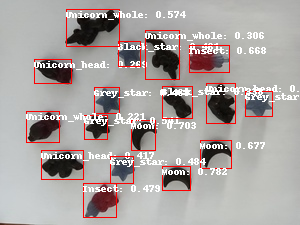

In [25]:
# Load the image
image = Image.open("cd_35.jpg")

# Run the object detection pipeline
obj_detector = pipeline("object-detection", model="candy_detector")
results = obj_detector(image, threshold=0.22)

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)

# change for loop form from tutorial, previous form was throwing indexing and type errors
for result in results:
    score = result["score"]
    label = result["label"]
    box = result["box"]

    # box is a dictionary, extract and round values
    box = [round(v, 2) for k,v in box.items()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), f"{label}: {round(score, 3)}", fill="white")

# display the image with bounding boxes
image

Below is the candy_counter() function.

In [26]:
# create candy counter function, takes single image as input and returns a dictionary of the candy counts within it

# assuming the input is a path to an image of candy
def candy_count(image):

    # Load the image
    img = Image.open(image)

    # Run the object detection pipeline
    obj_detector = pipeline("object-detection", model="candy_detector")
    results = obj_detector(img, threshold=0.22)

    # take the dictionary that maps labels to ids and set all of the values to 0
    # use this as the output dictionary to store candy counts
    count_dict = dict.fromkeys(label2id, 0)

    # iterate through all bounding boxes
    for item in results:

        # grab the label of the candy for the boudning box
        candy_type = item["label"]

        # locate this label in the dictionary and add 1 to its value
        # this is counting how many times this type of candy was detected in the image
        count_dict[candy_type] += 1

    return count_dict

# testing function
out = candy_count("cd_35.jpg")

print(out)

{'Black_star': 2, 'Cat': 0, 'Grey_star': 4, 'Insect': 2, 'Moon': 3, 'Owl': 0, 'Unicorn_head': 3, 'Unicorn_whole': 3}
